In [1]:
%load_ext autoreload

%autoreload 2

from RNN2DFA.LSTM import LSTMNetwork
# from GRU import GRUNetwork
from RNN2DFA.RNNClassifier import RNNClassifier
from RNN2DFA.Training_Functions import mixed_curriculum_train
import Tomita_Grammars 
from RNN2DFA.Training_Functions import make_test_set,make_train_set_for_target
from RNNexplainer import Explainer
import pandas as pd
import LTL2DFA as ltlf2dfa





In [2]:
# Reber grammar
from specific_examples import Reber_Grammar
rg=Reber_Grammar()
alphabet=rg.alphabet
generator_dfa=rg
sample_train_set=[]
for i in range(100):
    seq, _, _ = rg.get_one_example(maxLength=10)
    sample_train_set.append(seq)
    # print(rg.classify_word(rg.sequenceToWord(seq)))

In [3]:
import specific_examples
generator_dfa=specific_examples.Email()
target_formula = generator_dfa.target_formula
alphabet = generator_dfa.alphabet
query_formulas = generator_dfa.query_formulas


In [4]:
# make training set
train_set = make_train_set_for_target(generator_dfa.classify_word,alphabet,max_train_samples_per_length=1000,search_size_per_length=3000)
print(train_set)


from sklearn.model_selection import train_test_split

def dict2lists(dictionary):
    X,y=[],[]
    for key in dictionary:
        X.append(key)
        y.append(dictionary[key])
    return X,y

def lists2dict(x,y):
    # both x and y should have same length
    assert len(x)==len(y), "Error dimension"
    d={}
    n=len(x)
    for idx in range(n):
        d[x[idx]]=y[idx]
    return d

print(len(train_set))
X,y=dict2lists(train_set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_set=lists2dict(X_train,y_train)
test_set=lists2dict(X_test, y_test)

print(len(train_set))
print(len(test_set))

print(len(train_set))
if(target_formula=="email match"):
    matching_strings=generator_dfa.generate_matching_strings(1000,20)
    for string in matching_strings:
        train_set[string]=True
print(len(train_set))

made train set of size: 488 , of which positive examples: 70
{'': False, 'a': False, 'r': False, 'n': False, 'm': False, 'q': False, 'p': False, 'd': False, 'mp': False, 'an': False, 'np': False, 'qr': False, 'qq': False, 'rp': False, 'pd': False, 'mn': False, 'qa': False, 'rr': False, 'dp': False, 'pr': False, 'nm': False, 'dn': False, 'qn': False, 'rm': False, 'dd': False, 'qp': False, 'nq': False, 'rd': False, 'nmd': False, 'mam': False, 'qqa': False, 'qqm': False, 'dmm': False, 'mqm': False, 'pmd': False, 'nmn': False, 'nrq': False, 'pqn': False, 'ann': False, 'dnd': False, 'rra': False, 'mnr': False, 'ppa': False, 'par': False, 'rdm': False, 'mdr': False, 'rpr': False, 'dqn': False, 'raqd': True, 'qaqd': True, 'rapd': True, 'qard': True, 'rard': True, 'papd': True, 'paqd': True, 'qapd': True, 'pard': True, 'qpar': False, 'qqpp': False, 'qqrp': False, 'nrqm': False, 'aqda': False, 'andr': False, 'rrmm': False, 'nrpa': False, 'mana': False, 'ppqp': False, 'mqqp': False, 'dqda': Fals

In [5]:
fout=open("output/log.txt", "a")
fout.write(".........................................................................\n")
fout.write("Target: "+ target_formula)
fout.write("\n")
fout.close()


# define rnn
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)


# train the model
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)
rnn.renew()  
dfa_from_rnn=rnn 
# statistics

def percent(num,digits=2):
    tens = pow(10,digits)
    return int(100*num*tens)/tens

print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = 0
rnn_target = 0
for w in test_set:
    if generator_dfa.classify_word(w):
        pos+=1

    if dfa_from_rnn.classify_word(w)==generator_dfa.classify_word(w):
        rnn_target+=1
print("rnn score against target on test set:                             ",rnn_target,"("+str(percent(rnn_target/n))+")")

# dfa_from_rnn=generator_dfa

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.
current average loss is:  0.03289095032044122
current average loss is:  0.007020788905821499
current average loss is:  0.0021246351198613883
current average loss is:  0.0005755082355835094
classification loss on last batch was: 0.0004910322097530893
testing on train set, i.e. test set is train set
test set size: 162
rnn score against target on test set:                              160 (98.76)


In [9]:


# use a query LTL formula
query_formula="F(a)"
query_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=query_formula, token="bal")
# print(query_dfa)
"""  
Create initial samples
"""


from RNNexplainer import Traces
traces=Traces(rnn, alphabet, token="bal")
traces.label_from_network([])
traces.write_in_file()




from PACTeacher.pac_teacher import PACTeacher as Teacher 
explainer=Explainer(alphabet=[character for character in alphabet], token="bal")
teacher = Teacher(dfa_from_rnn,epsilon=.03, delta=.03, max_trace_length=20, max_formula_depth=10, query_dfa=query_dfa)



import time
start_time=time.time()
from multiprocessing import Process, Queue
explainer, flag= teacher.teach(explainer, traces, timeout = 15)
end_time=time.time()


print("\n\nepsilon=", teacher.epsilon, "delta=", teacher.delta, "max_trace_length=", teacher.max_trace_length)
print("query:", query_formula)
print("final ltl: ", explainer.ltl)

fout=open("output/log.txt", "a")
fout.write("\n\nquery: "+query_formula)
fout.write("\nfinal LTL: "+ explainer.ltl)

new_delta = None
new_epsilon = None
if(not flag):
    fout.write(" [incomplete]")
    print("incomplete formula")
    new_delta, new_epsilon = teacher.calculate_revised_delta_and_epsilon()
    print(new_delta, new_epsilon)

fout.write("\n\n")

print("returned counterexamples:", teacher.returned_counterexamples)

print("\nTime taken:", end_time-start_time)
fout.close()


fout=open("output/log.txt", "a")
# fout.write("rnn score against target on test set:                             "+str(rnn_target)+"("+str(percent(rnn_target/n))+")")
# fout.write("\n")

performance_ltl_wo_query = performance_ltl_with_target_wo_query = performance_ltl = performance_ltl_with_target = 0


for w in test_set:
    
    if dfa_from_rnn.classify_word(w)==explainer.dfa.classify_word(w):
        performance_ltl_wo_query+=1
    if explainer.dfa.classify_word(w)==generator_dfa.classify_word(w):
        performance_ltl_with_target_wo_query +=1
    if (dfa_from_rnn.classify_word(w) and query_dfa.classify_word(w)) == explainer.dfa.classify_word(w):
        performance_ltl+=1
    if explainer.dfa.classify_word(w) == (generator_dfa.classify_word(w) and query_dfa.classify_word(w)):
        performance_ltl_with_target +=1

print("extracted LTL score against rnn on test set:                      ",performance_ltl_wo_query,"("+str(percent(performance_ltl_wo_query/n))+")")

print("extracted LTL score against target on rnn's test set:             ",performance_ltl_with_target_wo_query,"("+str(percent(performance_ltl_with_target_wo_query/n))+")")

print("extracted LTL score against rnn on test set (with query):         ",performance_ltl,"("+str(percent(performance_ltl/n))+")")

print("extracted LTL score against target on rnn's test set (with query):",performance_ltl_with_target,"("+str(percent(performance_ltl_with_target/n))+")")

fout.close()


# report in a pandas file
result = pd.DataFrame(columns=['target', 
                                'query', 
                                'explanation', 
                                'status', 
                                'rnn score', 
                                'explanation score', 
                                'explanation score on ground truth',
                                'extraction time',
                                'revised delta',
                                'revised epsilon',
                                'counterexamples',
                                'train size',
                                'test size'
                                ])

result = result.append(
    {
        'target':target_formula,
        'query':query_formula,
        'explanation':explainer.ltl,
        'status':flag,
        'rnn score':percent(rnn_target/n),
        'explanation score':percent(performance_ltl/n),
        'explanation score on ground truth':percent(performance_ltl_with_target/n),
        'extraction time': end_time-start_time, 
        'revised delta': new_delta, 
        'revised epsilon': new_epsilon, 
        'counterexamples': teacher.returned_counterexamples,
        'train size': len(train_set),
        'test size': len(test_set)
    }, ignore_index=True
)
print(result.to_string(index=False))
result.to_csv('output/result.csv', header=False, index=False, mode='a')


DFA:->
 - alphabet: ['a', 'b', 'c']
 - Q: [1, 2, 3]
 - q0: 1
 - F: [3]
 - delta: {1: {'000': 2, '001': 2, '010': 2, '011': 2, '100': 3, '101': 3, '110': 3, '111': 3}, 2: {'000': 2, '001': 2, '010': 2, '011': 2, '100': 3, '101': 3, '110': 3, '111': 3}, 3: {'000': 3, '001': 3, '010': 3, '011': 3, '100': 3, '101': 3, '110': 3, '111': 3}}
 - is_singleton_graph: False


positive traces---> 
[]


negative traces---> 
[]



Learning formula with depth 0
learned LTL formula: true
Learning took:  0.04138803482055664  s
EQ test took  0.0013239383697509766  s
new counterexample:   should be rejected by implementation


positive traces---> 
[]


negative traces---> 
['']



0  iteration complete



Learning formula with depth 0
learned LTL formula: false
Learning took:  0.043192148208618164  s
EQ test took  0.026535987854003906  s
new counterexample: a  should be accepted by implementation


positive traces---> 
['a']


negative traces---> 
['']



1  iteration complete



start formula depth: 1
B

['qard', 'p']
['qard', 'p']
provided counterexamples are: ['qard', 'p']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 1


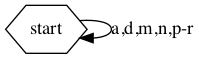

storing provided counterexample of length 4
returning counterexample of length 4:		qard, this counterexample is accepted by the given RNN.
equivalence checking took: 0.012406999999999613
obs table refinement took 0.013
guided starting equivalence query for DFA of size 5


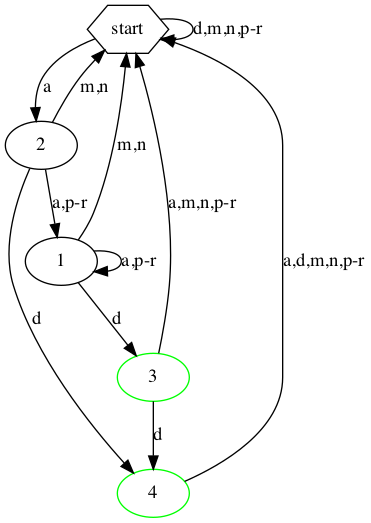

returning counterexample of length 3:		apd, this counterexample is rejected by the given RNN.
equivalence checking took: 0.013003000000001208
obs table refinement took 0.115
guided starting equivalence query for DFA of size 10


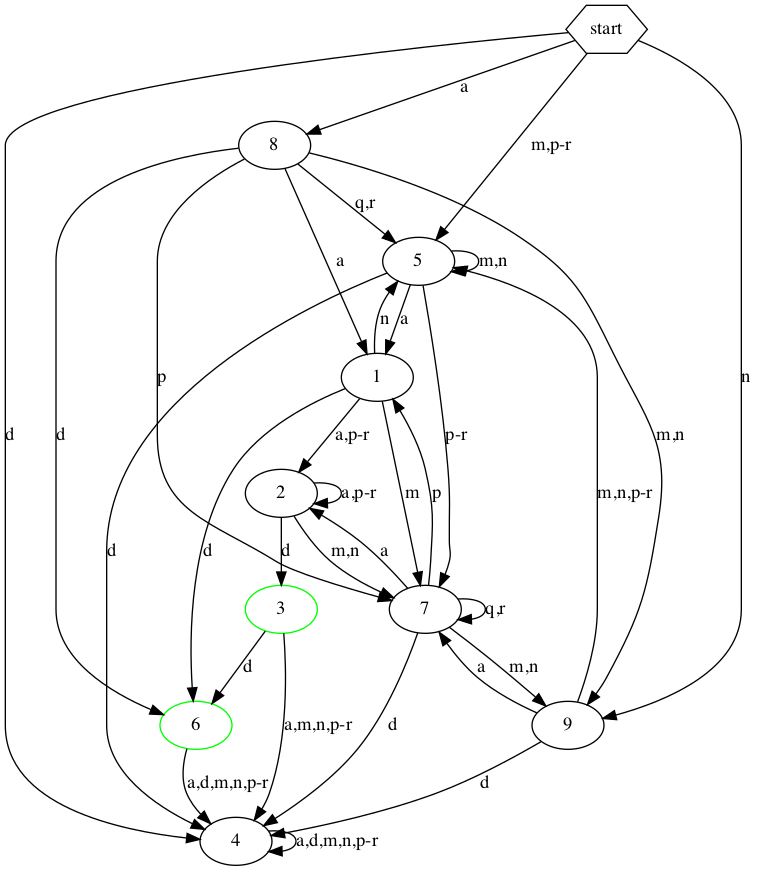

split wasn't perfect: gotta start over
returning counterexample of length 5:		mradd, this counterexample is rejected by the given RNN.
equivalence checking took: 0.043227999999999156
obs table refinement took 0.137
guided starting equivalence query for DFA of size 19


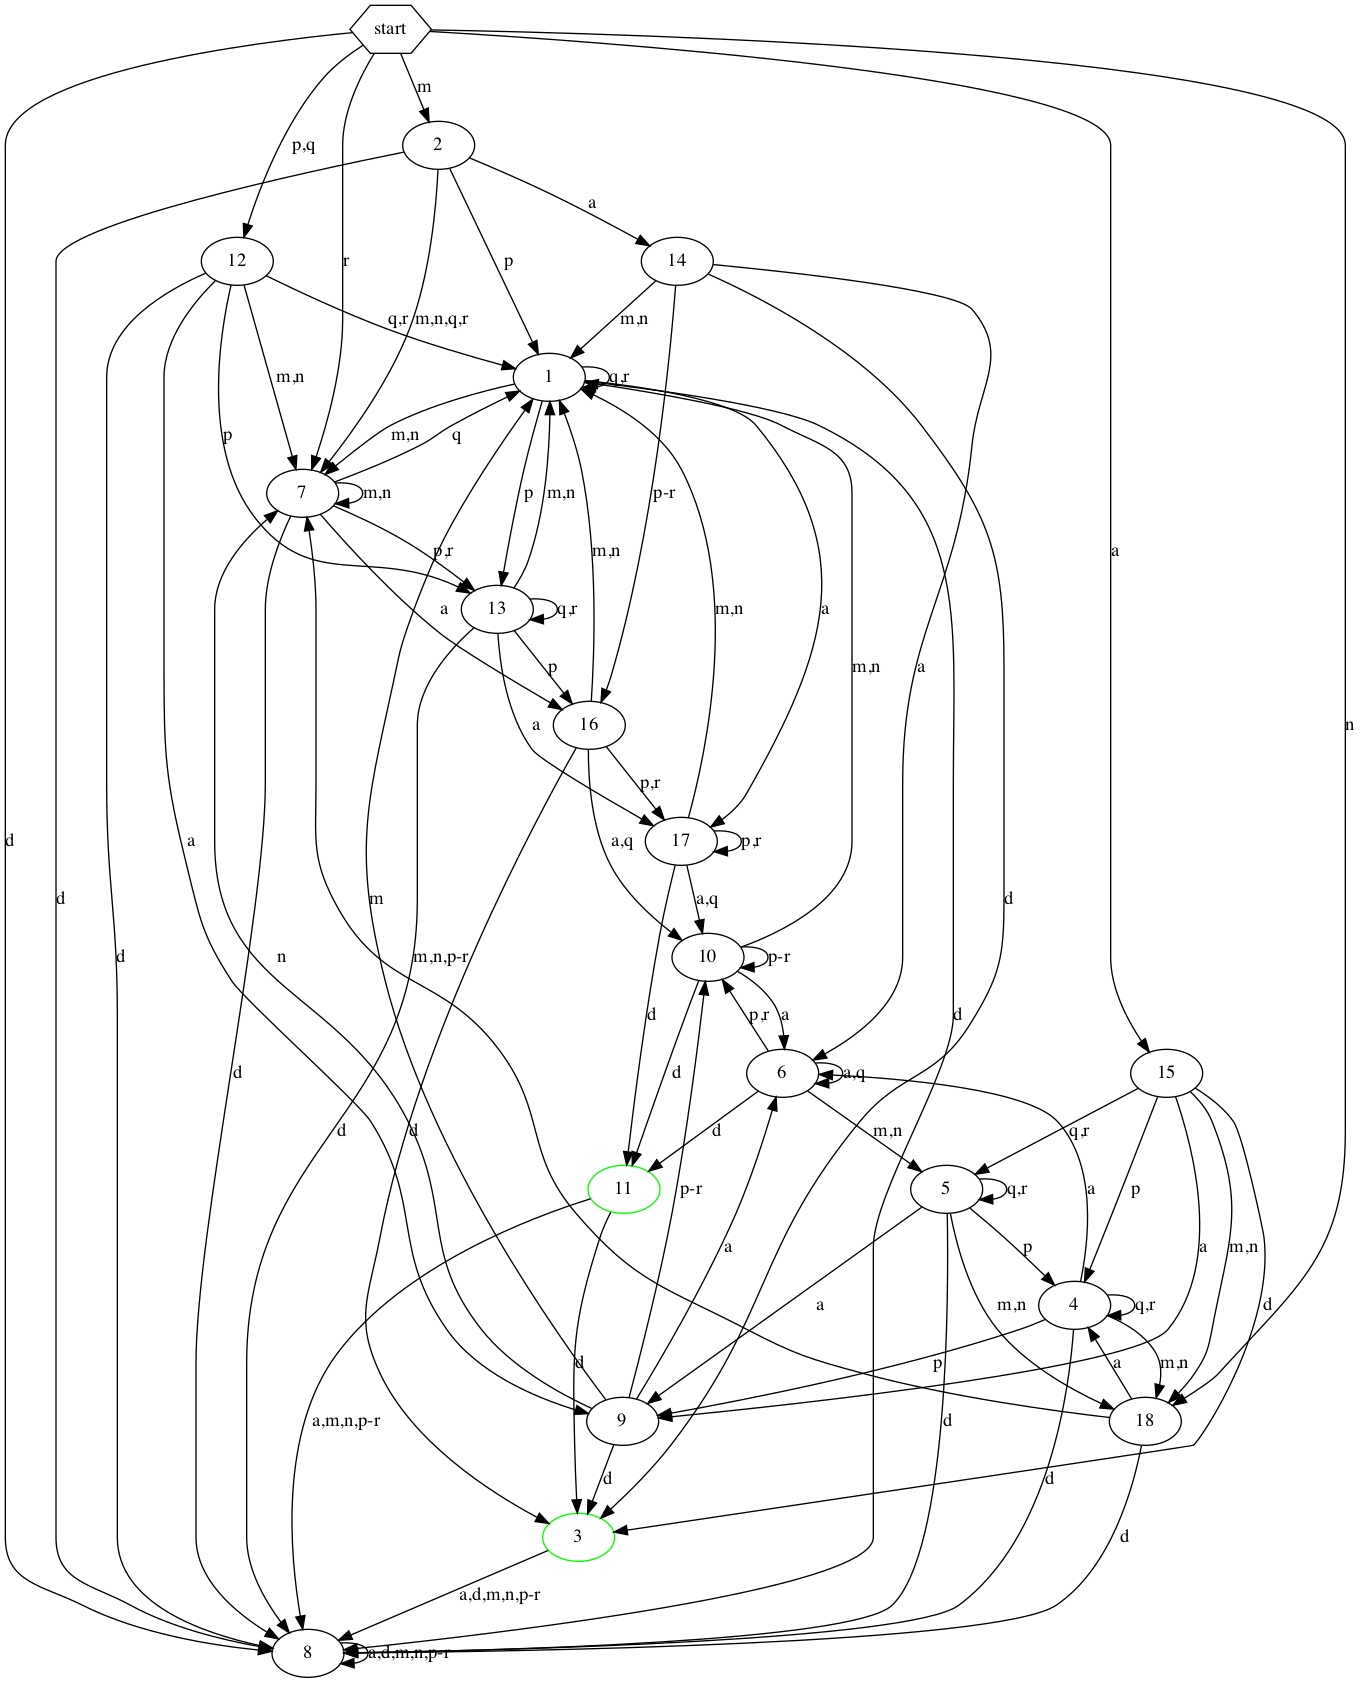

returning counterexample of length 6:		namaqd, this counterexample is accepted by the given RNN.
equivalence checking took: 0.016308999999999685
obs table refinement took 0.411
guided starting equivalence query for DFA of size 32
returning counterexample of length 6:		nrrpqd, this counterexample is accepted by the given RNN.
equivalence checking took: 0.0019570000000008747
obs table refinement took 1.409
guided starting equivalence query for DFA of size 64
returning counterexample of length 5:		mprqd, this counterexample is rejected by the given RNN.
equivalence checking took: 0.00277499999999975
obs table refinement took 1.369
guided starting equivalence query for DFA of size 88
returning counterexample of length 5:		nppqd, this counterexample is accepted by the given RNN.
equivalence checking took: 0.002428000000001873
obs table refinement took 3.105
guided starting equivalence query for DFA of size 132
returning counterexample of length 5:		pnnad, this counterexample is accepted by 

In [6]:
from RNN2DFA.Extraction import extract
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnn.classify_word(w)==True),None)
neg = next((w for w in all_words if rnn.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]
print(starting_examples)
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnn.classify_word(w)==True),None)
neg = next((w for w in all_words if rnn.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]
print(starting_examples)
dfa_lstar = extract(rnn,time_limit = 50,initial_split_depth = 10,starting_examples=starting_examples)